# Analyze RB

Small notebook to play around a bit and do some testing runs.

In [47]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import psutil
p = psutil.Process()
p.cpu_affinity([0])
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import jax.numpy as jnp
import jax 
from jimgw.single_event.likelihood import HeterodynedTransientLikelihoodFD, TransientLikelihoodFD
from jimgw.single_event.waveform import RippleTaylorF2, RippleIMRPhenomD_NRTidalv2
from jimgw.prior import Uniform, Composite
import pickle
import time
from astropy.time import Time
from tqdm import tqdm
jax.config.update("jax_enable_x64", True)
print(jax.devices())

import utils
import pandas as pd

[CpuDevice(id=0)]


In [39]:
trigger_time = 1187008882.43
gmst = Time(trigger_time, format='gps').sidereal_time('apparent', 'greenwich').rad
N_samples = 1_00

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

## Load the data

In [56]:
filename = "evaluated_likelihoods/injection_8.npz"
data = np.load(filename)

log_likelihood = data["log_likelihood"]
log_likelihood_original = data["log_likelihood_original"]
samples = data["samples"]

diffs = abs(log_likelihood - log_likelihood_original)
rel_diffs = abs((log_likelihood - log_likelihood_original) / log_likelihood_original)

# Show max, min, mean, std, and median
for name, d in zip(["diffs", "rel_diffs"], [diffs, rel_diffs]):
    print(f"Stats for {name} \n")
    
    print(f"Max: {d.max()}")
    print(f"Min: {d.min()}")
    print(f"Mean: {d.mean()}")
    print(f"Std: {d.std()}")
    print(f"Median: {np.median(d)}")


Stats for diffs 

Max: 52.98932727034048
Min: 0.0019976366405671797
Mean: 4.8613252052500515
Std: 8.876982568722118
Median: 1.4061216801622791
Stats for rel_diffs 

Max: 0.9643562341794687
Min: 3.660631237572643e-06
Mean: 0.07057823721423727
Std: 0.15450588216561653
Median: 0.014675216566652502


In [60]:
# Try to find if there is a clear correlation between high diffs and one of the samples parameters
for i, name in enumerate(utils.naming):
    corr = np.corrcoef(diffs, samples[:, i])[0, 1]
    print(f"{name}: {corr}")

M_c: -0.414138783341315
q: -0.12262162685721206
s1_z: -0.08736776141885538
s2_z: 0.0646388120409381
lambda_1: -0.19663230584588837
lambda_2: 0.017104157138188168
d_L: -0.2487929898948188
t_c: -0.10131860782211535
phase_c: -0.004132672845800512
cos_iota: 0.1343240507178919
psi: -0.019961711819335724
ra: -0.058025405652512525
sin_dec: 0.008730713263184876


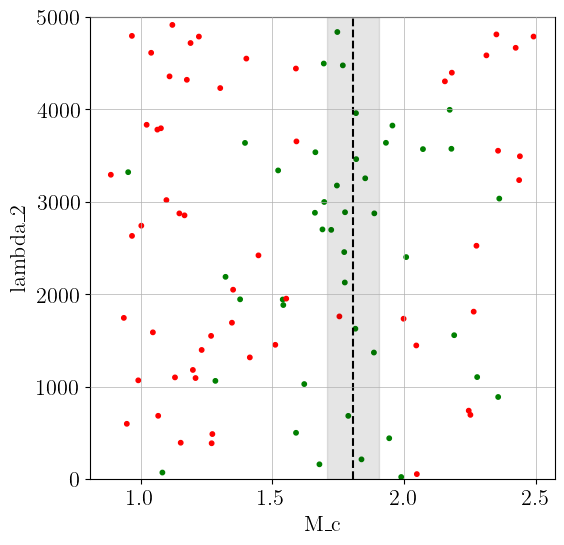

In [81]:
idx, idy = 0, 5
namex, namey = utils.naming[idx], utils.naming[idy]
x_array, y_array = samples[:, idx], samples[:, idy]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

threshold = 1e-2
colors = np.where(rel_diffs > threshold, "red", "green")

scatt = ax.scatter(x_array, y_array, c=colors, s=10)
ax.set_xlabel(namex)
ax.set_ylabel(namey)
# cbar = plt.colorbar(scatt, ax=ax)
# cbar.set_label('Diff')
true_val = 1.8055220463362418
plt.axvline(true_val, color="black", linestyle="--")
true_std = 0.1
plt.fill_between([true_val - true_std, true_val + true_std], [0, 0], [5000, 5000], color="black", alpha=0.1)
plt.ylim(0, 5000)
            
plt.savefig(f"./figures/scatterplot_{namex}_{namey}.png")
plt.show()
plt.close()

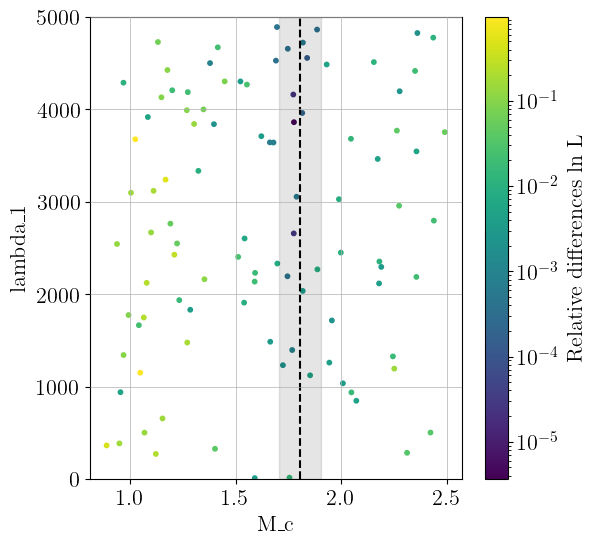

In [80]:
idx, idy = 0, 4
namex, namey = utils.naming[idx], utils.naming[idy]
x_array, y_array = samples[:, idx], samples[:, idy]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

scatt = ax.scatter(x_array, y_array, c=rel_diffs, s=10, cmap="viridis",  norm=LogNorm())
ax.set_xlabel(namex)
ax.set_ylabel(namey)
cbar = plt.colorbar(scatt, ax=ax)
cbar.set_label('Relative differences ln L')
true_val = 1.8055220463362418
plt.axvline(true_val, color="black", linestyle="--")
true_std = 0.1
plt.fill_between([true_val - true_std, true_val + true_std], [0, 0], [5000, 5000], color="black", alpha=0.1)
plt.ylim(0, 5000)
plt.savefig(f"./figures/scatterplots/scatterplot_{namex}_{namey}.png")
plt.show()
plt.close()
        
### Iterate over all combinations and make a plot        
# for idx in range(len(utils.naming)):
#     for idy in range(idx, len(utils.naming)):
        
#         namex = utils.naming[idx]
#         namey = utils.naming[idy]
        
#         x_array, y_array = samples[:, idx], samples[:, idy]
#         fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#         scatt = ax.scatter(x_array, y_array, c=diffs, s=10, cmap="viridis",  norm=LogNorm())
#         ax.set_xlabel(namex)
#         ax.set_ylabel(namey)
#         cbar = plt.colorbar(scatt, ax=ax)
#         cbar.set_label('Diff')
#         plt.savefig(f"./figures/scatterplots/scatterplot_{namex}_{namey}.png")
#         # plt.show()
#         plt.close()

In [66]:
# # Get the parameters as a dict:
# params_logL_dict = {}
# for i, name in enumerate(utils.naming):
#     params_logL_dict[name] = samples[:, i]
# params_logL_dict["logL"] = log_likelihood
# params_logL_dict["logL_original"] = log_likelihood_original
# params_logL_dict["diffs"] = diffs

# # Create pandas dataframe out of it
# df = pd.DataFrame(params_logL_dict)

# # Sort based on Log L differences
# df = df.sort_values(by="diffs", ascending=False)
# df.head(20)